In [1]:
import sys
# import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
# import lightkurve as lk
# from scipy.optimize import curve_fit

# from astropy.convolution import Gaussian1DKernel
# from astropy.convolution import convolve
sys.path.insert(0, "../")

from michael import janet

Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

In [9]:
j = janet.boot(uni, index=11)

Making folder /Users/oliver hall/Research/unicorn/data/2000862299280251136/...
Found star in Sector(s) 16 17


No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.


### Running Simple Astropy Lomb-Scargle on Sector 16 on star 2000862299280251136 ###
### Completed Simple Astropy Lomb-Scargle for Sector 16 on star 2000862299280251136 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 17 on star 2000862299280251136 ###
### Completed Simple Astropy Lomb-Scargle for Sector 17 on star 2000862299280251136 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector all on star 2000862299280251136 ###
### Completed Simple Astropy Lomb-Scargle for Sector all on star 2000862299280251136 ###
### Saved results ###
### Running Wavelet Estimation on star 2000862299280251136 ###



### Completed Wavelet Estimation on star 2000862299280251136 ###
### Saved results ###
### Running ACF Estimation on star 2000862299280251136 ###
### Completed ACF Estimation on star 2000862299280251136 ###
### Saved results ###

------ Decoding Overall Period Flag 129 ------
128: The ACF period does not match the 'best' period within 2 sigma.
1: Best rotation is from the Simple Lomb Scargle (SLS) method.

No other flags raised. 



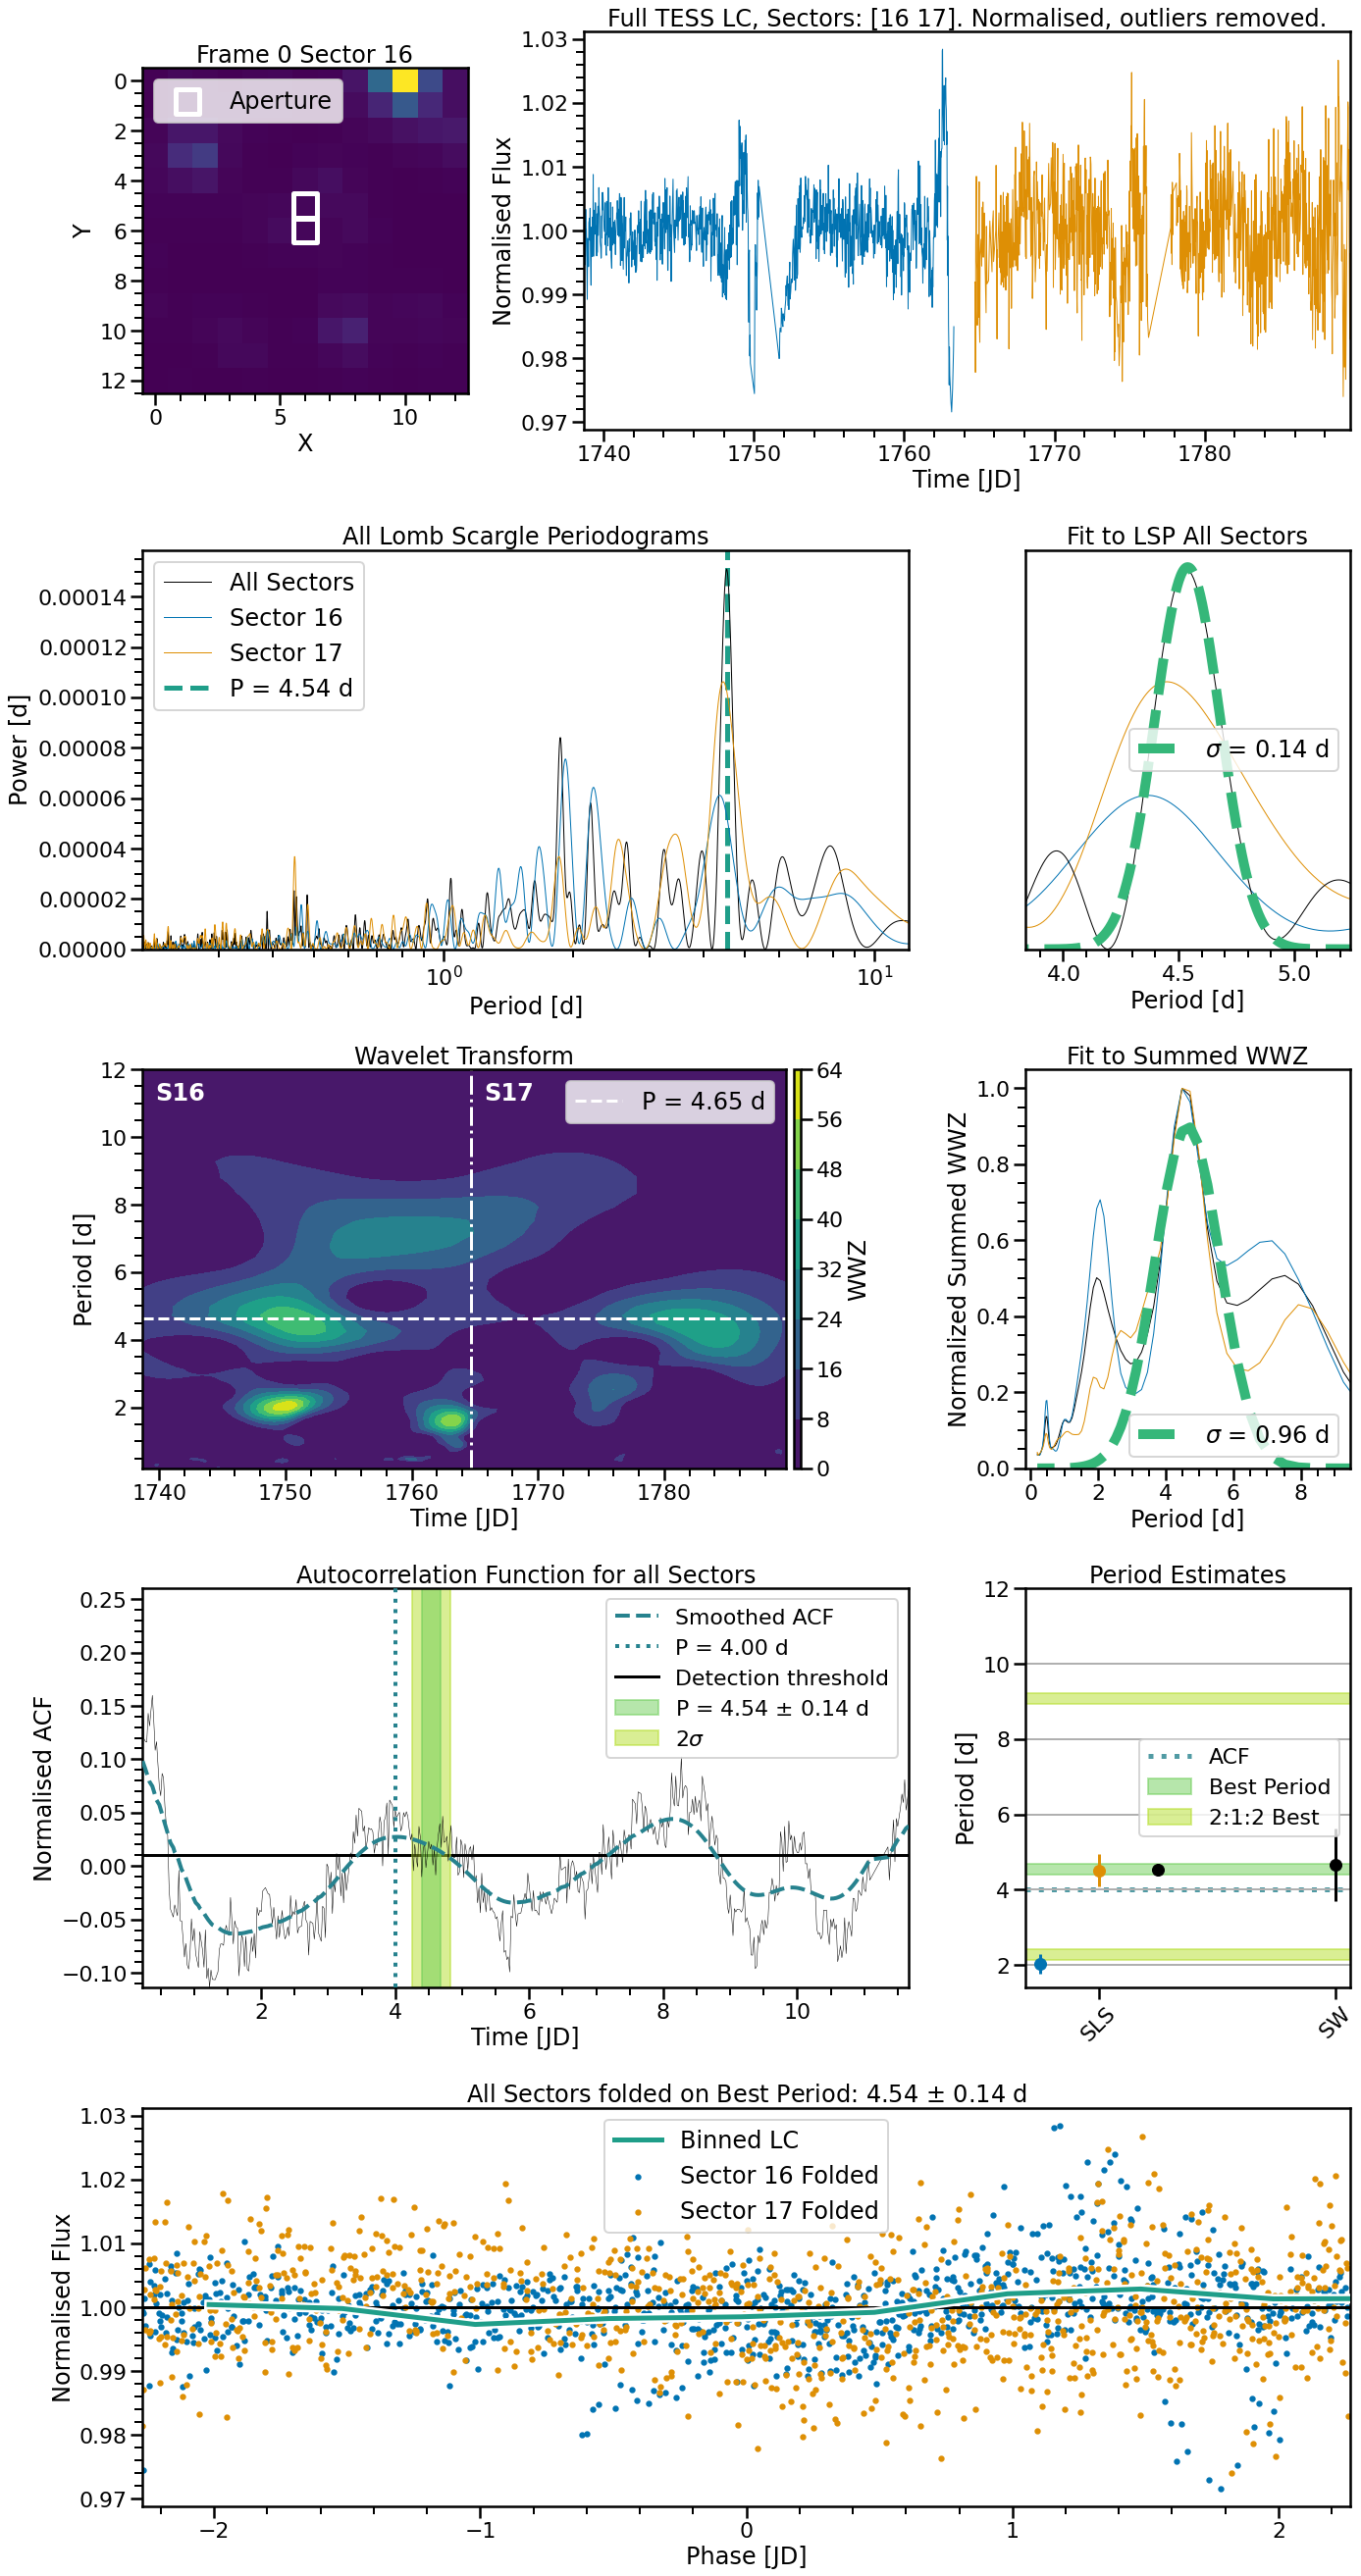

In [10]:
j.run()

In [11]:
import lightkurve as lk


In [12]:
lk.__version__

'2.0.7'

In [18]:
fold = j.void['clc_all'].fold(4.54)

In [ ]:
fold.bin()

In [ ]:
j.void['clc_all'].bin